# 50.007 Machine Learning Project
- 1005153 Yap Zhan Hao, Sean
- 1004866 Wang Yueheng
- 1004867 Wang Zhuoran
- 1004885 Guo Yuchen
- 1004874 Wang Shiyu 

## Import libraries and prepare data sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import csv

In [2]:
def mergeArray(a1, a2):
    a1 = a1[:, np.newaxis]
    a2 = a2[:, np.newaxis]
    return np.concatenate((a1, a2), axis=1)

def write_pred(filename, ids, pred):
    with open(filename, "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["id", "label"])
        write_lst = mergeArray(ids, pred)
        for r in write_lst:
            writer.writerow(r)

In [2]:
df = pd.read_csv("data/train_tfidf_features.csv")
test_df = pd.read_csv("data/test_tfidf_features.csv")

In [3]:
train_features = df.drop(["label","id"], axis = 1).to_numpy()
train_targets = df["label"].to_numpy()

unseen_x = test_df.drop(["id"], axis = 1).to_numpy()
id_lst = test_df["id"].to_numpy()

# holdout
train_x, test_x, train_y, test_y = train_test_split(train_features, train_targets, test_size=0.3, random_state=20)

In [39]:
print(train_x.shape)
print(test_x.shape)
#print(id_lst.shape)

(12028, 5000)
(5156, 5000)
(4296,)


## Task 1: Logistic Regression

### Implementation

In [44]:
#n: number of feature; m: number of training examples; x: input matrix(m*n); y: 1/0
#  ; w : weight (n*1) ; b: bias ; y_hat: between 0 and 1(p)

def sigmoid(z):
    return 1.0/(1+np.exp(-z))

#y_hat
def hypothesis(w, X,b):
    return sigmoid(np.dot(X,w)+b)

# need to minimize
def loss(y, y_hat):
    J = -np.mean(y*(np.log(y_hat))-(1-y)*np.log(1-y_hat))
    return J

#find partial derivative
def gradients(X, y, y_hat):
    m = X.shape[0]
    residuals = y_hat - y
    dw = (1/m)*np.dot(X.T, residuals)
    db = (1/m)*np.sum(residuals)
    return dw, db

def normalize(X):
    m,n=X.shape
    for i in range(n):
        X=(X-X.mean(axis=0))/X.std(axis=0)
    return X

def train(X, y, bs, epochs, lr):
    m,n=X.shape
    w=np.zeros((n,1))
    b=0
    y=y.reshape(m,1)
    #x=normalize(X)
    lossList=[]
    for i in range(epochs):
        for j in range((m-1)//bs+1):
            start=j*bs
            end=start+bs
            xb=X[start:end]
            yb=y[start:end]
            y_hat=hypothesis(w,xb,b)
            dw,db=gradients(xb,yb,y_hat)
            w-=lr*dw
            b-=lr*db
        y_hat_now=hypothesis(w,X,b)
        ls=loss(y,y_hat_now)
        lossList.append(ls)
    return w, b, lossList

def predict(X, w, b):
    #x=normalize(X)
    predictions=[]
    y_hat=hypothesis(w,X,b)
    #print(y_hat)
    predictions=[1 if i>0.5 else 0 for i in y_hat]
    return np.array(predictions)

#how to use‘

w,b,l=train(train_x,train_y,50,1000,0.01)
#print(w,b,l)
test_predict = predict(unseen_x, w, b)
#df_pred=pd.DataFrame(test_predict)
#df_test=pd.DataFrame(test_x)
#print(df_pred)
#print(test_x)
#df_log=pd.concat([df_test,df_pred],axis=1,join='inner').T
#print(df_log)
write_pred('LogRed_Prediction.csv', id_lst, test_predict)


In [ ]:
# DDW implementation
def normalize_z(dfin):
    mean_in = dfin.mean(axis=0)
    std_in = dfin.std(axis=0)
    
    dfout = (dfin - mean_in)/std_in

    return dfout

def log_regression(beta, X):
    return 1/(1+np.exp(-np.matmul(X,beta)))

def compute_cost_logreg(beta, X, y):
    np.seterr(divide = 'ignore') 

    rows = X.shape[0]
    hypo = log_regression(beta, X)
    J = np.sum(-1/rows * np.where(y == 0, np.log2(1-hypo), np.log2(hypo)))

    np.seterr(divide = 'warn')
    return J

def gradient_descent_logreg(X, y, beta, alpha, num_iters):
    rows = X.shape[0]
    J_storage = np.empty((num_iters,1))
    for i in range(num_iters):
        hypo = log_regression(beta,X)
        residuals = hypo - y
        beta = beta - (alpha/rows)*np.matmul(X.T, residuals)
        J_storage[i] = compute_cost_logreg(beta, X, y)

    return beta, J_storage

def predict_norm(X, beta):
    pred = log_regression(beta, X)
    return np.where(pred < 0.5, 0,1)

def predict(xmat, beta):
    X = normalize_z(xmat)    # standardize and prepare feature
    y_hat = predict_norm(X, beta)
    return y_hat

beta = np.zeros((train_x.shape[1], 1))

beta, costs = gradient_descent_logreg(train_x, train_y, beta, 0.01, 1500)

pred = predict(test_x, beta)


### Testing

In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(train_x, train_y)

pred = model.predict(test_x)
model.score(test_x, test_y)

c:\Users\wyhzu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7294414274631498

In [32]:
pred = model.predict(unseen_x)
#print(pred)
write_pred('predictions/logreg_skl.csv', id_lst, pred)

[1 0 1 ... 1 0 0]


## Task 2: Dimension Reduction

In [4]:
import random as rd

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [5]:
df_concat_pca = np.concatenate((train_features, unseen_x))

#pd.concat([train_features, unseen_x], ignore_index=True)
df_concat_pca

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
#pca of concat features with 100 components

pca_100 = PCA(n_components=100)
pca_100.fit(df_concat_pca)
new_features_100 = pca_100.transform(df_concat_pca)

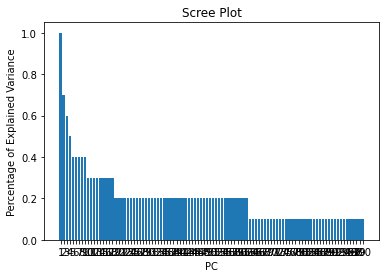

In [14]:
variance_100 = pca_100.explained_variance_ratio_
#print(variance_100)
per_var = np.round(variance_100*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('PC')
plt.title('Scree Plot')
plt.show()

In [10]:
#pca of concat features with 500 components

pca_500 = PCA(n_components=500)
pca_500.fit(df_concat_pca)
new_features_500 = pca_500.transform(df_concat_pca)

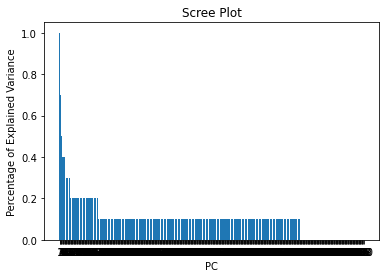

In [15]:
variance_500 = pca_500.explained_variance_ratio_
#print(variance_500)
per_var = np.round(variance_500*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('PC')
plt.title('Scree Plot')
plt.show()

In [12]:
#pca of concat features with 1000 components

pca_1000 = PCA(n_components=1000)
pca_1000.fit(df_concat_pca)
new_features_1000 = pca_1000.transform(df_concat_pca)

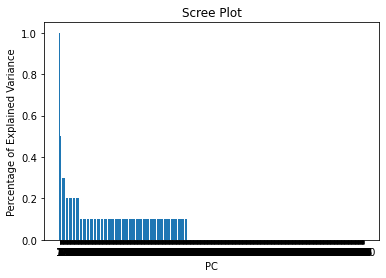

In [16]:
variance_1000 = pca_1000.explained_variance_ratio_
#print(variance_1000)
per_var = np.round(variance_1000*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('PC')
plt.title('Scree Plot')
plt.show()

In [6]:
#pca of concat features with 2000 components

pca_2000 = PCA(n_components=2000)
pca_2000.fit(df_concat_pca)
new_features_2000 = pca_2000.transform(df_concat_pca)

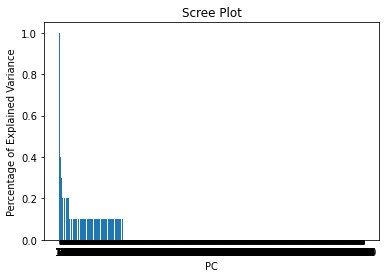

In [7]:
variance_2000 = pca_2000.explained_variance_ratio_
#print(variance_2000)
per_var = np.round(variance_2000*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('PC')
plt.title('Scree Plot')
plt.show()

In [ ]:
#cut train and tests

new_features_100_train = new_features_100[:17184]
new_features_500_train = new_features_500[:17184]
new_features_1000_train = new_features_1000[:17184]
new_features_2000_train = new_features_2000[:17184]

test_features_100 = new_features_100[17184:]
test_features_500 = new_features_500[17184:]
test_features_1000 = new_features_1000[17184:]
test_features_2000 = new_features_2000[17184:]

In [ ]:
#KNN modeling
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(new_features_100_train, train_targets)

#predict result with component of 100
predict_100 = knn.predict(test_features_100)

df_predict_100 = pd.DataFrame(predict_100, columns = ['label'])
df_100 = pd.concat([id_lst, df_predict_100], axis = 1)

In [ ]:
#KNN modeling
knn.fit(new_features_500_train, train_targets)

#predict result with component of 500
predict_500 = knn.predict(test_features_500)

df_predict_500 = pd.DataFrame(predict_500, columns = ['label'])
df_500 = pd.concat([id_lst, df_predict_500], axis = 1)

In [ ]:
#KNN modeling
knn.fit(new_features_1000_train, train_targets)

#predict result with component of 1000
predict_1000 = knn.predict(test_features_1000)

df_predict_1000 = pd.DataFrame(predict_1000, columns = ['label'])
df_1000 = pd.concat([id_lst, df_predict_1000], axis = 1)

In [ ]:
#KNN modeling
knn.fit(new_features_2000_train, train_targets)

#predict result with component of 2000
predict_2000 = knn.predict(test_features_2000)

df_predict_2000 = pd.DataFrame(predict_2000, columns = ['label'])
df_2000 = pd.concat([id_lst, df_predict_2000], axis = 1)

In [ ]:
#write prediction to csv files
df_100.to_csv('pred_100.csv', index=False)
df_500.to_csv('pred_500.csv', index=False)
df_1000.to_csv('pred_1000.csv', index=False)
df_2000.to_csv('pred_2000.csv', index=False)

## Task 3: Improvements + Other Models

### Cross Validation/ Subsampling

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def subsample(model, X, y, test_size=0.2, reps=3):
    f_lst = [0]*reps
    
    for i in range(reps):
        print(f"Rep {i} ...")
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        f_lst[i] = f1_score(y_test, pred)
    
    return np.array(f_lst)


In [ ]:
subsample(LogisticRegression(), train_features, train_targets)

Rep 0...
Rep 1...
Rep 2...


([0.575812274368231, 0.5909712722298222, 0.5712988192552225],
 0.5793607886177585,
 0.008414088048972134)

### Support Vector Machine

In [ ]:
svm_model = LinearSVC(dual = False, C=50.0)

svm_model.fit(train_x,train_y)

pred = svm_model.predict(test_x)
train_score = svm_model.score(train_x, train_y)
test_score = svm_model.score(test_x, test_y)

print(train_score, test_score)


0.9186897239773861 0.6666020170674942


In [ ]:
predictions = svm_model.predict(unseen_x)
write_pred('prediction_svm_50.csv', id_lst, predictions)

### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(10,))

clf.fit(train_x, train_y)
pred_nn = clf.predict(test_x)
print(clf.score(test_x, test_y))
f_score(pred_nn, test_y)

c:\Users\yapzh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.56519533231862

In [ ]:
nn_measures = dict()
nn_measures[0] = subsample(train_features, train_targets, MLPClassifier(hidden_layer_sizes=(10)), test_size=0.3)
nn_measures[1] = subsample(train_features, train_targets, MLPClassifier(hidden_layer_sizes=(50)), test_size=0.3)
nn_measures[2] = subsample(train_features, train_targets, MLPClassifier(hidden_layer_sizes=(100)), test_size=0.3)


In [ ]:
nn_measures

{0: ([0.5597579425113465, 0.5464124435524336, 0.5479313824419778],
  0.551367256168586,
  0.005965428557641294),
 1: ([0.5602365114560236, 0.5625, 0.5595622979358369],
  0.5607662697972868,
  0.001256451691484269),
 2: ([0.5847225678029361, 0.5734477536597677, 0.5928834355828221],
  0.5836845856818419,
  0.007968458157691427)}

### Decision Trees/ Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(train_x, train_y)
prds = clf.predict(test_x)
f_score(prds, test_y)

0.596617687829221

In [ ]:
clf.fit(train_features, train_targets)
preds = clf.predict(unseen_x)

write_pred('random_forest.csv', id_lst, preds)

### Boosting

1. Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# optimise hyperparameters
gbc = GradientBoostingClassifier(learning_rate=0.2, n_estimators=100, subsample=0.8, min_samples_split=50, min_samples_leaf=50, max_depth=15,  max_features="sqrt")
# 'max_depth':(8,15,20,50,80,100), 'min_samples_split':(1,2,5),'min_samples_leaf':(2,5,10),'learning_rate':(0.05,0.1,0.2),'n_estimators':(80,100,200,300)
parameters = {'max_depth':(8,15,20,50,80,100)}

clf = GridSearchCV(gbc, parameters)
clf.fit(train_x, train_y)

clf.cv_results_

In [ ]:
# clf = GradientBoostingClassifier(loss='deviance',learning_rate=0.1, n_estimators=300, warm_start=True,subsample=1, criterion= 'squared_error', min_samples_split=2, min_samples_leaf=5, max_depth=50,  max_features="sqrt")
clf = GradientBoostingClassifier(learning_rate=0.2, n_estimators=300, subsample=0.8, min_samples_split=50, min_samples_leaf=50, max_depth=80,  max_features="sqrt")
clf.fit(train_x, train_y)
prds = clf.predict(test_x)
print(f1_score(prds, test_y))

clf.fit(train_features, train_targets)
preds = clf.predict(unseen_x)
write_pred('predictions/GradientBoostingClassifier.csv', id_lst, preds)

2. AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier #For Classification
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier()
clf = AdaBoostClassifier(n_estimators=200, base_estimator=dtree,learning_rate=0.1)
clf.fit(train_x, train_y)
prds = clf.predict(test_x)
print(f1_score(prds, test_y))
# 0.5622119815668203

0.5622119815668203


3. xgboost

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier(learning_rate=0.01, max_depth=100, n_estimators=100)
clf.fit(train_x, train_y)
prds = clf.predict(test_x)
print(f1_score(prds, test_y))
# 0.5514261019878997

0.5514261019878997


4. Stacking Classifier
- ps: 2 layers are not proved efficient

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier #For Classification
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Create Learners per layer
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=200, random_state=42,max_depth=50)),
                        ('bnb_1', BernoulliNB(alpha = 0.6))             
                       ]

clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=LogisticRegression())
clf.fit(train_x, train_y)
prds = clf.predict(test_x)
print(f1_score(prds, test_y))

clf.fit(train_features, train_targets)
preds = clf.predict(unseen_x)
write_pred('predictions/StackingClassifier_rd_bnb.csv', id_lst, preds)
# 0.6198895027624309

0.6198895027624309


In [ ]:
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=200, random_state=42,max_depth=50)),
                        ('knn_1', BernoulliNB(alpha = 0.6)),
                        ('dt_2', DecisionTreeClassifier(max_depth=50))             
                       ]
clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=LogisticRegression())
clf.fit(train_x, train_y)
prds = clf.predict(test_x)
print(f1_score(prds, test_y))
clf.fit(train_features, train_targets)
preds = clf.predict(unseen_x)
write_pred('predictions/StackingClassifier_rd_bnb_dt.csv', id_lst, preds)
# 0.6210526315789474

0.6210526315789474


In [ ]:
# best predictions、
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=300, random_state=42,max_depth=80)),
                        ('bnb_1', BernoulliNB(alpha = 0.6)),
                        ('dt_1', DecisionTreeClassifier(max_depth=80)),
                        ("knn_1",KNeighborsClassifier(n_neighbors=15))             
                       ]
clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=LogisticRegression())
clf.fit(train_x, train_y)
prds = clf.predict(test_x)
print(f1_score(prds, test_y))
clf.fit(train_features, train_targets)
preds = clf.predict(unseen_x)
write_pred('predictions/StackingClassifier_rd_bnb_dt_250_80.csv', id_lst, preds)
# 0.6263345195729536

0.6263345195729536
